# 데이터 불균형

- 신용카드 도용 탐지
- 2013년 유럽의 카드 사용 내역 (2일간)
- 불균형 데이터 처리
 - SMOTE
 - RandomOverSampler
 - ADASYN
 - (참고) SMOTENC(categorical_features=[18, 19]))

In [2]:
import pandas as pd
import numpy as np 
import matplotlib.pyplot as plt
import warnings
warnings.filterwarnings("ignore")
%matplotlib inline
%config InlineBackend.figure_format = 'retina'

In [3]:
from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix, classification_report,roc_curve, roc_auc_score
from sklearn.metrics import plot_precision_recall_curve,precision_recall_curve, average_precision_score
from imblearn.over_sampling import SMOTE, SMOTENC, ADASYN, RandomOverSampler

- 데이터 다운로드 66M

In [4]:
!curl -L https://bit.ly/2nweJrO -o credit.csv.zip

  % Total    % Received % Xferd  Average Speed   Time    Time     Time  Current
                                 Dload  Upload   Total   Spent    Left  Speed
100   147  100   147    0     0   2333      0 --:--:-- --:--:-- --:--:--  2333
100   143    0   143    0     0    541      0 --:--:-- --:--:-- --:--:--   541
100   318  100   318    0     0    565      0 --:--:-- --:--:-- --:--:--     0
100  1076    0  1076    0     0   1288      0 --:--:-- --:--:-- --:--:--  1288
100 65.9M  100 65.9M    0     0  29.9M      0  0:00:02  0:00:02 --:--:-- 74.0M


In [5]:
!unzip -o credit.csv.zip

Archive:  credit.csv.zip
  inflating: creditcard.csv          


In [6]:
card_df = pd.read_csv('./creditcard.csv')
print(card_df.shape)
card_df.head(3)

(284807, 31)


,Time,V1,V2,V3,V4,V5,V6,V7,V8,V9,V10,V11,V12,V13,V14,V15,V16,V17,V18,V19,V20,V21,V22,V23,V24,V25,V26,V27,V28,Amount,Class
0,0.0,-1.359807,-0.072781,2.536347,1.378155,-0.338321,0.462388,0.239599,0.098698,0.363787,0.090794,-0.551600,-0.617801,-0.991390,-0.311169,1.468177,-0.470401,0.207971,0.025791,0.403993,0.251412,-0.018307,0.277838,-0.110474,0.066928,0.128539,-0.189115,0.133558,-0.021053,149.62,0
1,0.0,1.191857,0.266151,0.166480,0.448154,0.060018,-0.082361,-0.078803,0.085102,-0.255425,-0.166974,1.612727,1.065235,0.489095,-0.143772,0.635558,0.463917,-0.114805,-0.183361,-0.145783,-0.069083,-0.225775,-0.638672,0.101288,-0.339846,0.167170,0.125895,-0.008983,0.014724,2.69,0
2,1.0,-1.358354,-1.340163,1.773209,0.379780,-0.503198,1.800499,0.791461,0.247676,-1.514654,0.207643,0.624501,0.066084,0.717293,-0.165946,2.345865,-2.890083,1.109969,-0.121359,-2.261857,0.524980,0.247998,0.771679,0.909412,-0.689281,-0.327642,-0.139097,-0.055353,-0.059752,378.66,0


In [7]:
card_df["Class"].value_counts()

0    284315
1       492
Name: Class, dtype: int64

- 284,807개 중에 492개의 도용 데이터 (0.172%):불균형 데이터
- 차원축소된 (암호화된) (PCA:Priciple Component Analysis) 데이터 제공
- Time'(처음부터 초단위 경과시간), 거래액수: 'Amount'
- 목적변수, 'Class' 1이면 도용
- Time 컬럼 삭제

In [8]:
card_df = card_df.drop('Time', axis=1)

## 훈련 데이터, 검증 데이터 나누기
### 계층적 샘플링
- 마지막 컬럼이 목적변수(y)이며 이의 분포에 맞게 계층적 샘플링 (stratified)을 수행한다


In [9]:
X = card_df.iloc[:, :-1]
y = card_df.iloc[:, -1]
X_train, X_test, y_train, y_test = train_test_split(X, y, 
    random_state=9, stratify=y)

In [10]:
print('Train Data Fraud Ratio: ',(y_train == 1).mean().round(5))
print('Test Data Fraud Ratio: ',(y_test == 1).mean().round(5))

Train Data Fraud Ratio:  0.00173
Test Data Fraud Ratio:  0.00173


## 로지스틱 회귀
- 모델 생성 및 학습 수행

In [10]:
from sklearn.linear_model import LogisticRegression
lr_clf = LogisticRegression()
lr_clf.fit(X_train, y_train)

LogisticRegression(C=1.0, class_weight=None, dual=False, fit_intercept=True,
                   intercept_scaling=1, l1_ratio=None, max_iter=100,
                   multi_class='auto', n_jobs=None, penalty='l2',
                   random_state=None, solver='lbfgs', tol=0.0001, verbose=0,
                   warm_start=False)

## 성능평가
- 컨퓨전 매트릭스 보기
- 분류 성능 평가 (정확도, 리콜, 정밀도, F-1 점수)
- ROC, AUC, Precesion-Recall 그래프
 - 실제값: y_test
 - 예측값: y_pred

- 자주 사용하는 기능을 함수로 정의

In [24]:
def show_clf_result(y_test, y_pred):
  print(confusion_matrix(y_test, y_pred))
  print(classification_report(y_test, y_pred))

def draw_roc(y_test, score):
  fpr = dict()
  tpr = dict()
  roc_auc = dict()
  fpr, tpr, _ = roc_curve(y_test, score)
  roc_auc = roc_auc_score(y_test, score)
  plt.figure(figsize=(6,6))
  plt.plot(fpr, tpr, label='AUC = %0.4f)' % roc_auc)
  plt.plot([0, 1], [0, 1], linestyle='--')
  plt.xlim([0.0, 1.0])
  plt.ylim([0.0, 1.05])
  plt.xlabel('False Positive Rate')
  plt.ylabel('True Positive Rate')
  plt.title('ROC')
  plt.legend(loc="lower right")
  
def draw_pr(y_test, score):
  pre = dict()
  rcl = dict()
  ap = dict()
  pre, rcl, _ = precision_recall_curve(y_test, score)
  ap = average_precision_score(y_test, score)
  plt.figure(figsize=(6,6))
  plt.plot(rcl, pre, label='AP = %0.4f)' % ap)
  plt.xlim([0.0, 1.05])
  plt.ylim([0.0, 1.05])
  plt.xlabel('Recall')
  plt.ylabel('Precision')
  plt.legend(loc="lower right")

- 로지스틱 회귀 모델을 사용한 예측 수행
- 컨퓨전 매트릭스 및 최적의 성능 평가

In [12]:
y_pred = lr_clf.predict(X_test)
show_clf_result(y_test, y_pred)

[[71074     5]
 [   54    69]]
              precision    recall  f1-score   support

           0       1.00      1.00      1.00     71079
           1       0.93      0.56      0.70       123

    accuracy                           1.00     71202
   macro avg       0.97      0.78      0.85     71202
weighted avg       1.00      1.00      1.00     71202



- 정확도는 거의 1이 나오지만, 1 (카드도용)에 대한 리콜 값이 0.63으로 낮다
- 123개의 1중 77개를 찾았다 (77/123 = 0.63)

## ROC
- 먼저 분류 확률 (또는 점수)를 구한다

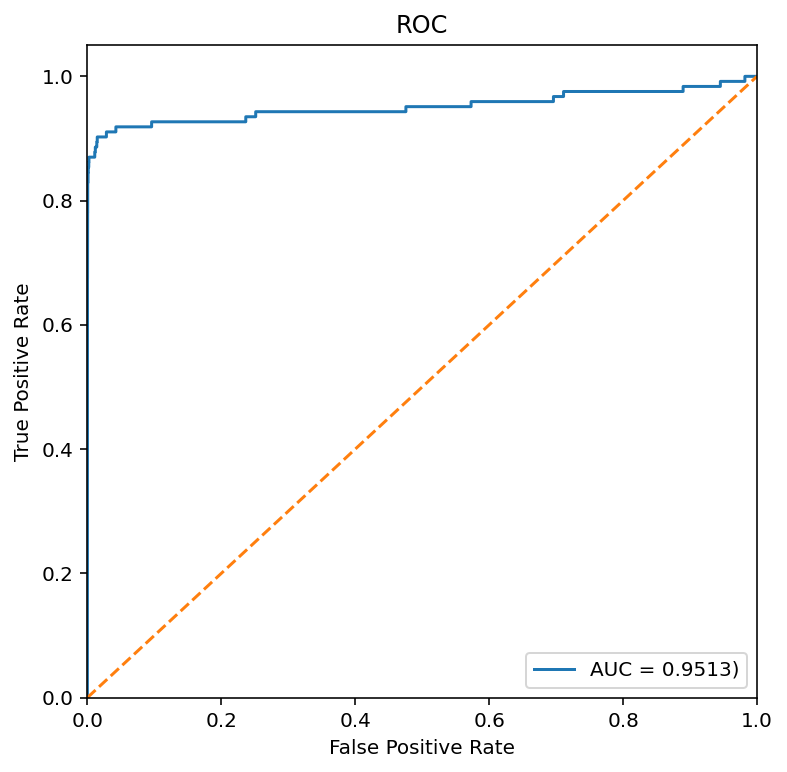

In [13]:
score = lr_clf.predict_proba(X_test)[:,1]
draw_roc(y_test, score)

In [14]:
X_test.shape, y_test.shape   

((71202, 29), (71202,))

In [15]:
 y_test.value_counts()

0    71079
1      123
Name: Class, dtype: int64

In [16]:
Z = pd.DataFrame(np.vstack((y_test.values, y_pred, score)).T, 
                 columns=['y','y_pred','score'])
Z[:3]

,y,y_pred,score
0,0.0,0.0,0.000168
1,0.0,0.0,0.000086
2,0.0,0.0,0.000505


- 불법 사용이라고 주장한 갯수는 81개이다

In [17]:
np.unique(y_pred, return_counts=True)

(array([0, 1]), array([71128,    74]))

In [18]:
np.unique(y_test, return_counts=True)

(array([0, 1]), array([71079,   123]))

- 점수가 높은 순으로 (1이라고 판단할 점수) 150개만 그려보겠다

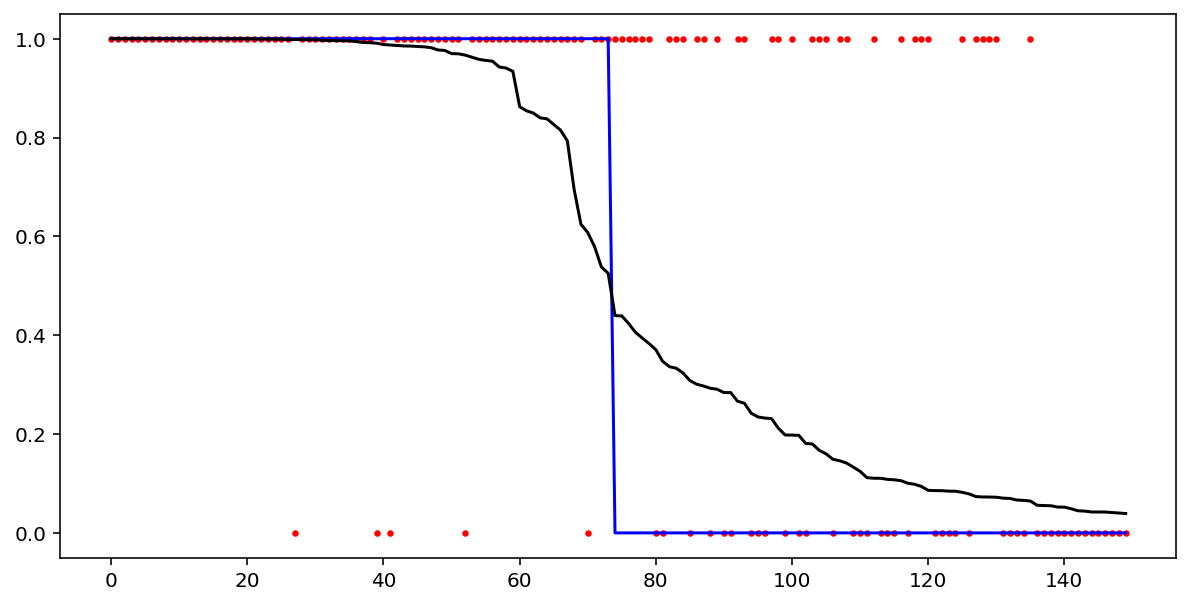

In [19]:
Z = Z.sort_values(by=['score'], ascending=False)
plt.figure(figsize=(10,5))
plt.scatter(range(150), Z['y'].values[:150], c='r', s=5)
plt.plot(Z['y_pred'].values[:150], c='b')
plt.plot(Z['score'].values[:150], c='k')


## 랜덤 포레스트

In [20]:
from sklearn.ensemble import RandomForestClassifier
rf_clf = RandomForestClassifier(n_estimators=30)
rf_clf.fit(X_train, y_train)

RandomForestClassifier(bootstrap=True, ccp_alpha=0.0, class_weight=None,
                       criterion='gini', max_depth=None, max_features='auto',
                       max_leaf_nodes=None, max_samples=None,
                       min_impurity_decrease=0.0, min_impurity_split=None,
                       min_samples_leaf=1, min_samples_split=2,
                       min_weight_fraction_leaf=0.0, n_estimators=30,
                       n_jobs=None, oob_score=False, random_state=None,
                       verbose=0, warm_start=False)

In [21]:
y_pred = rf_clf.predict(X_test)
show_clf_result(y_test, y_pred)

[[71078     1]
 [   27    96]]
              precision    recall  f1-score   support

           0       1.00      1.00      1.00     71079
           1       0.99      0.78      0.87       123

    accuracy                           1.00     71202
   macro avg       0.99      0.89      0.94     71202
weighted avg       1.00      1.00      1.00     71202



- 1에 대한 리콜이 77%로 올라갔다

## LightGBM
- 학습시에 불균형 데이터이면 반드시 boost_from_average=False로 설정해야 한다

In [23]:
from lightgbm import LGBMClassifier
lgbm_clf = LGBMClassifier(n_estimators=100,boost_from_average=False)
lgbm_clf.fit(X_train, y_train)

LGBMClassifier(boost_from_average=False, boosting_type='gbdt',
               class_weight=None, colsample_bytree=1.0, importance_type='split',
               learning_rate=0.1, max_depth=-1, min_child_samples=20,
               min_child_weight=0.001, min_split_gain=0.0, n_estimators=100,
               n_jobs=-1, num_leaves=31, objective=None, random_state=None,
               reg_alpha=0.0, reg_lambda=0.0, silent=True, subsample=1.0,
               subsample_for_bin=200000, subsample_freq=0)

In [24]:
y_pred = lgbm_clf.predict(X_test)
show_clf_result(y_test, y_pred)

[[71076     3]
 [   28    95]]
              precision    recall  f1-score   support

           0       1.00      1.00      1.00     71079
           1       0.97      0.77      0.86       123

    accuracy                           1.00     71202
   macro avg       0.98      0.89      0.93     71202
weighted avg       1.00      1.00      1.00     71202



- 리콜이 81%로 증가했다

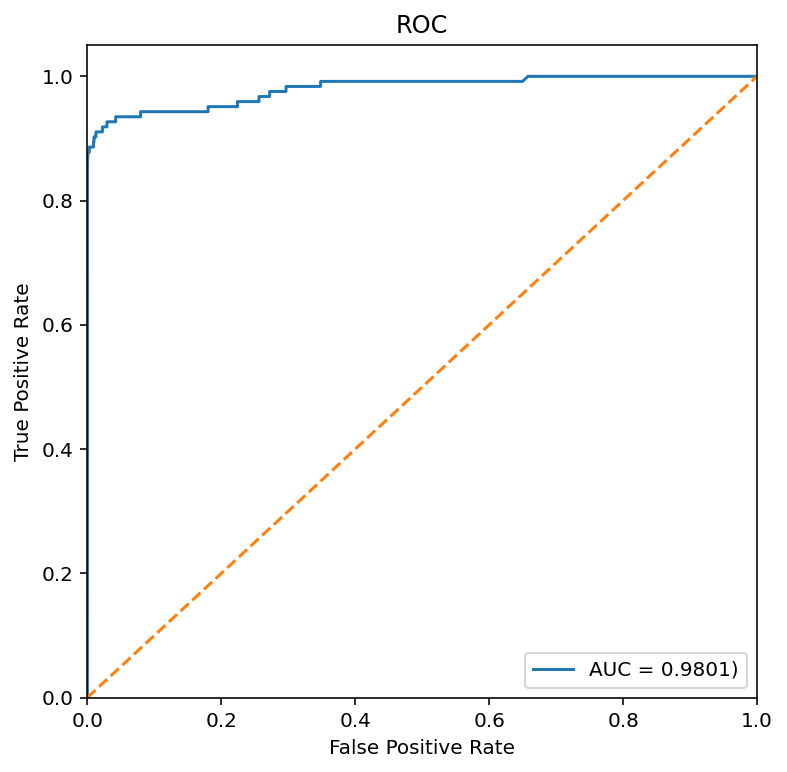

In [25]:
score = lgbm_clf.predict_proba(X_test)[:,1]
draw_roc(y_test, score)

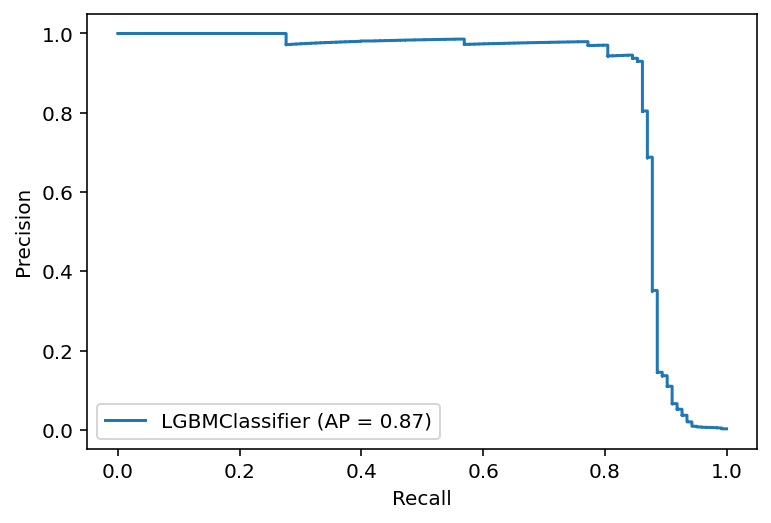

In [26]:
plot_precision_recall_curve(lgbm_clf, X_test, y_test)

# 데이터 전처리
- 로그변환
- 스케일링
- 이상치 제거


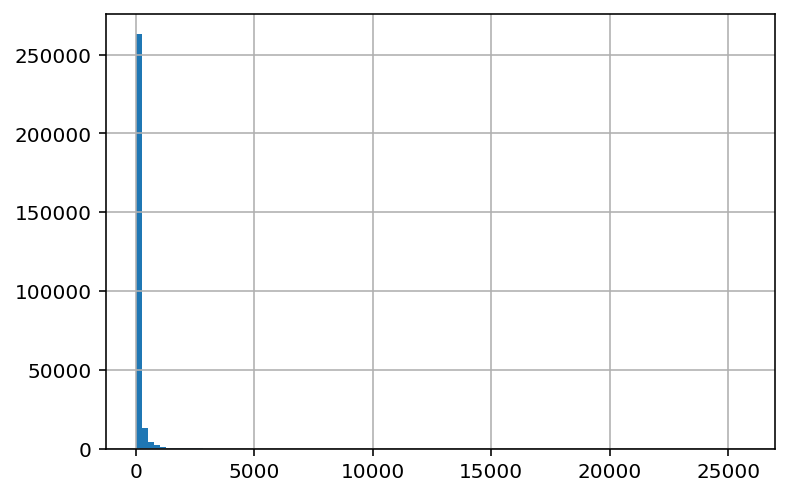

In [11]:
X['Amount'].hist(bins=100)

In [12]:
X['Amount'].describe()

count    284807.000000
mean         88.349619
std         250.120109
min           0.000000
25%           5.600000
50%          22.000000
75%          77.165000
max       25691.160000
Name: Amount, dtype: float64

- 돈관 관련된 데이터를 로그 변환을 한 후 스케일링을 한다

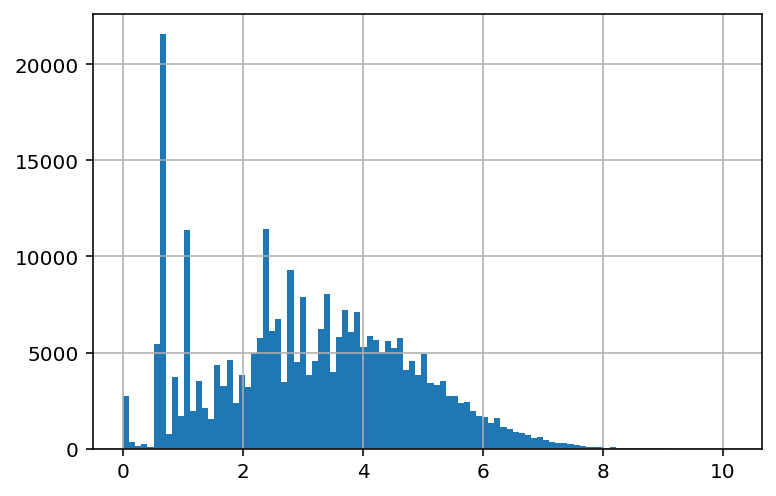

In [13]:
# log (1+x)
amount_log = np.log1p(X['Amount'])
amount_log.hist(bins=100)

In [14]:
from sklearn.preprocessing import StandardScaler
scaler = StandardScaler()
amount_sc = scaler.fit_transform(amount_log.values.reshape(-1,1))

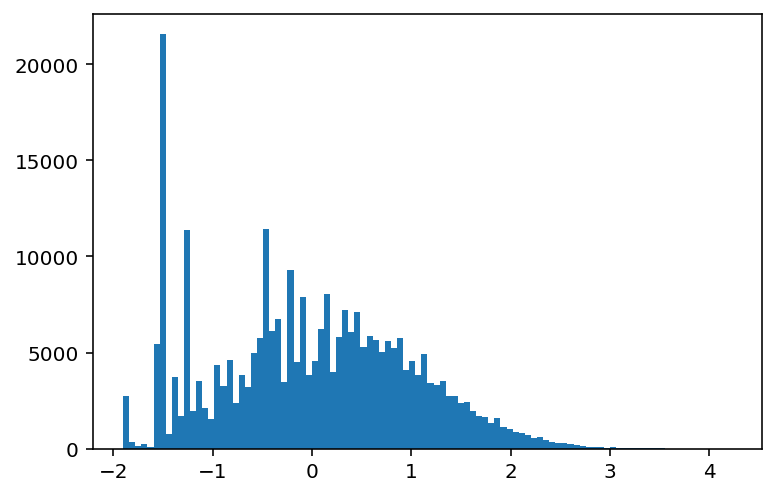

In [15]:
plt.hist(amount_sc, bins=100)
plt.show()

- 로그변환, 스케일링된 Amount를 사용한다
- 입력 데이터 (X)를 X_sc로 대체한다

In [16]:
X_sc = X.copy()
X_sc['Amount'] = amount_sc
X_sc[:3]

,V1,V2,V3,V4,V5,V6,V7,V8,V9,V10,V11,V12,V13,V14,V15,V16,V17,V18,V19,V20,V21,V22,V23,V24,V25,V26,V27,V28,Amount
0,-1.359807,-0.072781,2.536347,1.378155,-0.338321,0.462388,0.239599,0.098698,0.363787,0.090794,-0.551600,-0.617801,-0.991390,-0.311169,1.468177,-0.470401,0.207971,0.025791,0.403993,0.251412,-0.018307,0.277838,-0.110474,0.066928,0.128539,-0.189115,0.133558,-0.021053,1.124303
1,1.191857,0.266151,0.166480,0.448154,0.060018,-0.082361,-0.078803,0.085102,-0.255425,-0.166974,1.612727,1.065235,0.489095,-0.143772,0.635558,0.463917,-0.114805,-0.183361,-0.145783,-0.069083,-0.225775,-0.638672,0.101288,-0.339846,0.167170,0.125895,-0.008983,0.014724,-1.114639
2,-1.358354,-1.340163,1.773209,0.379780,-0.503198,1.800499,0.791461,0.247676,-1.514654,0.207643,0.624501,0.066084,0.717293,-0.165946,2.345865,-2.890083,1.109969,-0.121359,-2.261857,0.524980,0.247998,0.771679,0.909412,-0.689281,-0.327642,-0.139097,-0.055353,-0.059752,1.682368


- 아래에서 X_sc를 사용하는 것에 주의!
- 나머지 코드는 변화가 없다

In [17]:
X_train, X_test, y_train, y_test = train_test_split(X_sc, y,
                random_state=9, stratify=y)

In [34]:
lr_clf = LogisticRegression()
lr_clf.fit(X_train, y_train)
y_pred = lr_clf.predict(X_test)
show_clf_result(y_test, y_pred)

[[71075     4]
 [   54    69]]
              precision    recall  f1-score   support

           0       1.00      1.00      1.00     71079
           1       0.95      0.56      0.70       123

    accuracy                           1.00     71202
   macro avg       0.97      0.78      0.85     71202
weighted avg       1.00      1.00      1.00     71202



In [35]:
lgbm_clf = LGBMClassifier(n_estimators=100, boost_from_average=False)
lgbm_clf.fit(X_train, y_train)
y_pred = lgbm_clf.predict(X_test)
show_clf_result(y_test, y_pred)

[[71077     2]
 [   26    97]]
              precision    recall  f1-score   support

           0       1.00      1.00      1.00     71079
           1       0.98      0.79      0.87       123

    accuracy                           1.00     71202
   macro avg       0.99      0.89      0.94     71202
weighted avg       1.00      1.00      1.00     71202



In [79]:
rfc = RandomForestClassifier()
rfc.fit(X_train, y_train)
y_pred = rfc.predict(X_test)
show_clf_result(y_test, y_pred)

[[71078     1]
 [   28    95]]
              precision    recall  f1-score   support

           0       1.00      1.00      1.00     71079
           1       0.99      0.77      0.87       123

    accuracy                           1.00     71202
   macro avg       0.99      0.89      0.93     71202
weighted avg       1.00      1.00      1.00     71202



In [80]:
rfc = RandomForestClassifier(class_weight='balanced')
rfc.fit(X_train, y_train)
y_pred = rfc.predict(X_test)
show_clf_result(y_test, y_pred)

[[71077     2]
 [   27    96]]
              precision    recall  f1-score   support

           0       1.00      1.00      1.00     71079
           1       0.98      0.78      0.87       123

    accuracy                           1.00     71202
   macro avg       0.99      0.89      0.93     71202
weighted avg       1.00      1.00      1.00     71202



In [66]:
lgbm_clf = LGBMClassifier(n_estimators=100, boost_from_average=False)
lgbm_clf.fit(X_train, y_train)
y_pred = lgbm_clf.predict(X_test)
show_clf_result(y_test, y_pred)

[[71077     2]
 [   26    97]]
              precision    recall  f1-score   support

           0       1.00      1.00      1.00     71079
           1       0.98      0.79      0.87       123

    accuracy                           1.00     71202
   macro avg       0.99      0.89      0.94     71202
weighted avg       1.00      1.00      1.00     71202



In [39]:
# score = lgbm_clf.predict_proba(X_test)[:,1]
# draw_roc(y_test, score)

## MLP 신경망

In [18]:
# 신경망 라이브러리
import keras
from keras.models import Sequential
from keras.layers import Dense

classifier = Sequential()
classifier.add(Dense(units = 15 , activation = 'relu', input_dim = 29))
classifier.add(Dense(15, activation = 'relu'))
classifier.add(Dense(1, activation = 'sigmoid'))

# 환경 설정
classifier.compile(optimizer = 'adam', loss = 'binary_crossentropy', metrics = ['accuracy'])
# 학습
history = classifier.fit(X_train, y_train, batch_size=20, epochs=5,
                  validation_split=0.2, verbose=1)

# callbacks=[keras.callbacks.EarlyStopping(monitor='val_accuracy', patience=5)])

Epoch 1/10
8011/8011 [==============================] - 36s 4ms/step - loss: 0.0121 - accuracy: 0.9972 - val_loss: 0.0044 - val_accuracy: 0.9992
Epoch 2/10
8011/8011 [==============================] - 32s 4ms/step - loss: 0.0033 - accuracy: 0.9993 - val_loss: 0.0041 - val_accuracy: 0.9993
Epoch 3/10
8011/8011 [==============================] - 32s 4ms/step - loss: 0.0030 - accuracy: 0.9994 - val_loss: 0.0035 - val_accuracy: 0.9992
Epoch 4/10
8011/8011 [==============================] - 33s 4ms/step - loss: 0.0027 - accuracy: 0.9994 - val_loss: 0.0036 - val_accuracy: 0.9993
Epoch 5/10
8011/8011 [==============================] - 34s 4ms/step - loss: 0.0025 - accuracy: 0.9995 - val_loss: 0.0035 - val_accuracy: 0.9993
Epoch 6/10
8011/8011 [==============================] - 33s 4ms/step - loss: 0.0024 - accuracy: 0.9995 - val_loss: 0.0038 - val_accuracy: 0.9992
Epoch 7/10
8011/8011 [==============================] - 32s 4ms/step - loss: 0.0024 - accuracy: 0.9994 - val_loss: 0.0038 - val_ac

In [21]:
y_pred_p = classifier.predict(X_test)
y_pred = (y_pred_p.ravel() > 0.5)
y_pred

array([False, False, False, ..., False, False, False])

In [25]:
show_clf_result(y_test, y_pred)

[[71071     8]
 [   26    97]]
              precision    recall  f1-score   support

           0       1.00      1.00      1.00     71079
           1       0.92      0.79      0.85       123

    accuracy                           1.00     71202
   macro avg       0.96      0.89      0.93     71202
weighted avg       1.00      1.00      1.00     71202



In [26]:
classifier = Sequential()
classifier.add(Dense(units = 15 , activation = 'relu', input_dim = 29))
classifier.add(Dense(15, activation = 'relu'))
classifier.add(Dense(1, activation = 'sigmoid'))

# 환경 설정
classifier.compile(optimizer = 'adam', loss = 'binary_crossentropy', metrics = ['accuracy'])
# 학습
history = classifier.fit(X_train, y_train, batch_size=20, epochs=2, verbose=1)

# callbacks=[keras.callbacks.EarlyStopping(monitor='val_acc', patience=5)])

Epoch 1/2
10681/10681 [==============================] - 37s 3ms/step - loss: 0.0113 - accuracy: 0.9971
Epoch 2/2
10681/10681 [==============================] - 37s 3ms/step - loss: 0.0034 - accuracy: 0.9993


In [27]:
y_pred_p = classifier.predict(X_test)
y_pred = (y_pred_p.ravel() > 0.5)
show_clf_result(y_test, y_pred)

[[71072     7]
 [   33    90]]
              precision    recall  f1-score   support

           0       1.00      1.00      1.00     71079
           1       0.93      0.73      0.82       123

    accuracy                           1.00     71202
   macro avg       0.96      0.87      0.91     71202
weighted avg       1.00      1.00      1.00     71202



# 데이터 불균형
- 주로 오버샘플링을 한다 (언더 샘플링은 작은 수에 맞추는 것)
- 데이터 증식이 필요하다
- SMOTE(Synthetic Minority Over sampling Technique)
 - k 인접 샘플을 찾아서 사이의 값들을 추가로 사용한다
 - 파이썬의 imbalanced-learn 패키지 사용
- 범주형이 있을 때는 SMOTE-NC (Nomincal and Continuous)
- SMOTE 오버 샘플링은 학습 데이터에만 적용해야 한다

## SMOTE 사용

In [67]:
y_train.value_counts(normalize=True)

0    0.998273
1    0.001727
Name: Class, dtype: float64

In [41]:
y.shape, y_train.shape, y_test.shape

((284807,), (213605,), (71202,))

In [85]:
smote = SMOTE(random_state=9)
X_train_over, y_train_over = smote.fit_resample(X_train, y_train, ratio=0.5 )
X_train_over.shape, y_train_over.shape

TypeError: ignored

- 0과 1의 갯수를 큰 쪽에 맞추어 오버샘플링했다

In [87]:
np.unique(y_train_over, return_counts=True)

(array([0, 1]), array([213236, 213236]))

## 학습만 오버 샘플로 수행한다
- 검증은 원래의 데이터로만

In [70]:
lr_clf = LogisticRegression()
lr_clf.fit(X_train_over, y_train_over)
y_pred = lr_clf.predict(X_test)
show_clf_result(y_test, y_pred)

[[69024  2055]
 [    8   115]]
              precision    recall  f1-score   support

           0       1.00      0.97      0.99     71079
           1       0.05      0.93      0.10       123

    accuracy                           0.97     71202
   macro avg       0.53      0.95      0.54     71202
weighted avg       1.00      0.97      0.98     71202



- 1에 대한 리콜이 크게 향상되었지만 정밀도는 떨어진 것을 알 수 있다
- 정밀도 0.05는 매우 낮다

In [71]:
# score = lr_clf.predict_proba(X_test)[:,1]
# draw_roc(y_test, score)

In [72]:
# draw_pr(y_test, score)

- LightGBM 사용
- 오버 샘플을 사용한다

In [73]:
from lightgbm import LGBMClassifier
lgbm_clf = LGBMClassifier(n_estimators=100,boost_from_average=False)
lgbm_clf.fit(X_train_over, y_train_over)
y_pred = lgbm_clf.predict(X_test)
show_clf_result(y_test, y_pred)

[[71000    79]
 [   18   105]]
              precision    recall  f1-score   support

           0       1.00      1.00      1.00     71079
           1       0.57      0.85      0.68       123

    accuracy                           1.00     71202
   macro avg       0.79      0.93      0.84     71202
weighted avg       1.00      1.00      1.00     71202



- 리콜은 높지만(0.86) 정밀도는 낮다(0.57)

In [74]:
# score = lgbm_clf.predict_proba(X_test)[:,1]
# draw_roc(y_test, score)

In [75]:
# draw_pr(y_test, score)

## RandomOverSampler

In [76]:
ros = RandomOverSampler(random_state=9)
X_train_over, y_train_over = ros.fit_resample(X_train, y_train)
lgbm_clf = LGBMClassifier(n_estimators=100,boost_from_average=False)
lgbm_clf.fit(X_train_over, y_train_over)
y_pred = lgbm_clf.predict(X_test)
show_clf_result(y_test, y_pred)

[[71068    11]
 [   20   103]]
              precision    recall  f1-score   support

           0       1.00      1.00      1.00     71079
           1       0.90      0.84      0.87       123

    accuracy                           1.00     71202
   macro avg       0.95      0.92      0.93     71202
weighted avg       1.00      1.00      1.00     71202



## ADASYN (Adaptive Synthetic Sampling)

In [77]:
adasyn = ADASYN(random_state=9)
X_train_over, y_train_over = adasyn.fit_resample(X_train, y_train)
lgbm_clf = LGBMClassifier(n_estimators=100,boost_from_average=False)
lgbm_clf.fit(X_train_over, y_train_over)
y_pred = lgbm_clf.predict(X_test)
show_clf_result(y_test, y_pred)

[[70917   162]
 [   21   102]]
              precision    recall  f1-score   support

           0       1.00      1.00      1.00     71079
           1       0.39      0.83      0.53       123

    accuracy                           1.00     71202
   macro avg       0.69      0.91      0.76     71202
weighted avg       1.00      1.00      1.00     71202

